In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
import numpy as np
from itertools import combinations
from tqdm import tqdm

## Domain definition & initial particle positions

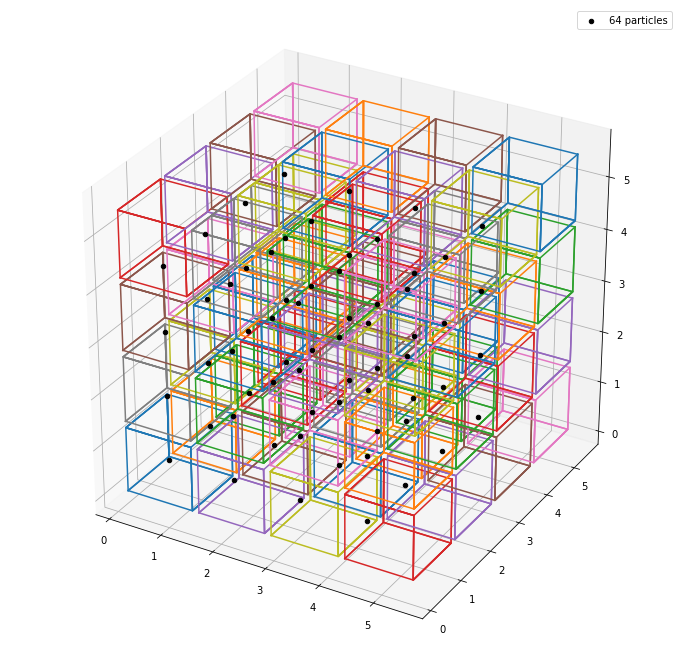

In [ ]:
L = RANGE = 5.0
CUBES_PER_DIM = 4 # this must be positive power of 2
PARTICLES = CUBES_PER_DIM**3-1
DIMS = 3 # 3-dimentional space
DENSITY = PARTICLES / (L**3)
TEMPERATURE = 2.0

# we split the space in cubes and assign particle positions
# in the center of each cube
# the space between cubes is just for visualization purposes,
# it does not exist in the arrays

def splitcubes(K, d):
    # d: dimension
    coords = [np.linspace(0, RANGE, num=K + 1) for i in range(d)]
    grid = np.stack(np.meshgrid(*coords)).T

    ks = list(range(1, K))
    for slices in product(*([[slice(b,e) for b,e in zip([None] + ks, [k+1 for k in ks] + [None])]]*d)):
        yield grid[slices]

def cubesets(K, d):
    if (K & (K - 1)) or K < 2:
        raise ValueError('K must be a positive power of 2. K: %s' % K)

    return [set(tuple(p.tolist()) for p in c.reshape(-1, d)) for c in splitcubes(K, d)]

def assemblecube(c, spread=.03):
    c = np.array(list(c))
    c = c[np.lexsort(c.T[::-1])]

    d = int(np.log2(c.size))
    for i in range(d):
        c[2**i:2**i + 2] = c[2**i + 1:2**i - 1:-1]

    # get the point farthest from the origin
    sp = c[np.argmax((c**2).sum(axis=1)**.5)]
    # shift all points a small distance towards that farthest point
    c += sp * .1 #np.copysign(np.ones(sp.size)*spread, sp)

    # create several different orderings of the same points so that matplotlib will draw a closed shape
    return [(np.roll(c, i, axis=1) - (np.roll(c, i, axis=1)[0] - c[0])[None,:]).T for i in range(d)]

initial_positions = []

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')


for i,c in enumerate(cubesets(CUBES_PER_DIM, DIMS)):
    # sum over x,y,z divided by 8 to find center of cube
    center_x = sum(i[0] for i in c)/8.0
    center_y = sum(i[1] for i in c)/8.0
    center_z = sum(i[2] for i in c)/8.0
    initial_positions.append([center_x, center_y, center_z])
    #print(c, center_x)
    
    ax.scatter(center_x, center_y, center_z, color='black', 
               label=f'{len(initial_positions)} particles' 
               if i == CUBES_PER_DIM**DIMS-1 else '')
    
    for cdata in assemblecube(c, spread=.05):
        #ax.view_init(elev=0, azim=0)
        ax.plot(*cdata, c=('C%d' % (i % 9)))

plt.legend()
plt.gcf().gca()
plt.show()

In [ ]:
DENSITY

0.504

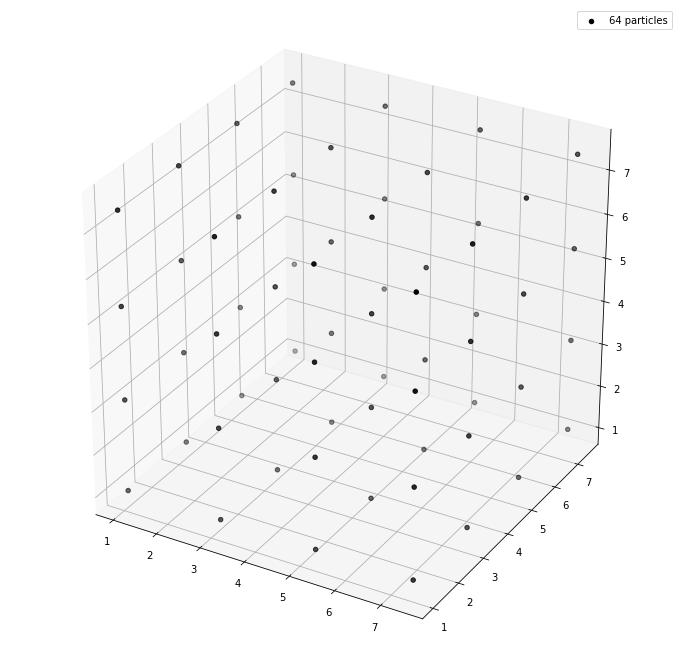

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

xs = [x[0] for x in initial_positions]
ys = [x[1] for x in initial_positions]
zs = [x[2] for x in initial_positions]

ax.scatter(xs, ys, zs, color='black', label=f'{len(initial_positions)} particles' 
           if i == CUBES_PER_DIM**DIMS-1 else '')
        
plt.legend()
plt.gcf().gca()
plt.show()

## Functions

In [ ]:
def lennard_jones(dist, e=1.0, sigma=1.0):
  # calculate LJ energy
  return 4.0*e*((sigma/dist)**12-(sigma/dist)**6)

def distance(a, b):
  # Calculate distances with minimum image convention
  dx = a[0]-b[0]
  dy = a[1]-b[1]
  dz = a[2]-b[2]

  if dx > L/2:
    dx -= L
  elif dx < -L/2:
    dx += L
  if dy > L/2:
    dy -= L
  elif dy < -L/2:
    dy += L
  if dz > L/2:
    dz -= L
  elif dz < -L/2:
    dz += L

  return dx**2 + dy**2 + dz**2

def total_energy(particles):
  # calculate total energy of the system
  energy = 0
  rad = RANGE/2
  # for every unique particle combination
  for pair in combinations(particles, 2):
    dist = distance(pair[0], pair[1])
    if dist <= rad:
      e = 4*(1/dist**6)-(1/dist**3) # powers are half because dist is not sqrt
      pair_energy_distr.append(e)
      dist_distr.append(dist)
      if time == STEPS - 1:
        dist_distr_final.append(dist)
      energy += e
  return energy

def periodic_boundary_check(particle):
  # check if particle moved out of bounds
  # and put it back in
  for i in range(len(particle)):
    if particle[i] > L:
      particle[i] -= L
    elif particle[i] < 0:
      particle[i] += L
  return particle

def metropolis(delta):
  # decide whether to accept new energy with metropolis algo
  if delta <= 0:
    return True
  u = np.random.uniform(0, 1)
  beta = 1.0/TEMPERATURE
  if np.exp(-beta * delta) > u:
    return True
  else:
    return False

## Simulation

100%|██████████| 1000/1000 [00:08<00:00, 112.48it/s]


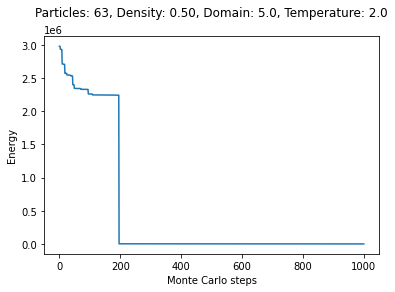

In [ ]:
STEPS = 1000
time = 0
particles = initial_positions.copy()
pair_energy_distr = []
dist_distr = []
dist_distr_init = []
dist_distr_final = []
energy = [total_energy(np.array(particles))]
dist_distr_init = dist_distr.copy()
rate = 0
av_energy = []
particle_pos = [particles]

for time in tqdm(range(0, STEPS), position=0, leave=True):
  if time % 100 == 0:
    # save for animation every 100 steps
    particle_pos.append(particles.copy())
  # Choose a particle to move at random.
  choice = np.random.randint(0, PARTICLES)
  temp = particles[choice].copy() # save it in case of rejection
  particles[choice][0] += np.random.uniform(0, RANGE)
  particles[choice][1] += np.random.uniform(0, RANGE)
  particles[choice][2] += np.random.uniform(0, RANGE)
  # move the particle temporarily and check boundaries
  particles[choice] = periodic_boundary_check(particles[choice])
  # calculate new energy and difference (delta)
  e = total_energy(np.array(particles))
  delta = np.array(e - energy[-1:][0], dtype=np.float128)
  # decide whether to accept/reject
  if metropolis(delta):
    energy.append(e)
    rate += 1
  else: # if rejected revert back
    particles[choice] = temp
    energy.append(energy[-1:][0])

  # running average for energy
  av_energy.append(sum(energy)/len(energy))

plt.plot(energy)
plt.title('Particles: {}, Density: {:.2f}, Domain: {}, Temperature: {}'.format(
    PARTICLES, DENSITY, RANGE, TEMPERATURE), pad=20)
plt.ylabel('Energy')
plt.xlabel('Monte Carlo steps')
plt.show()

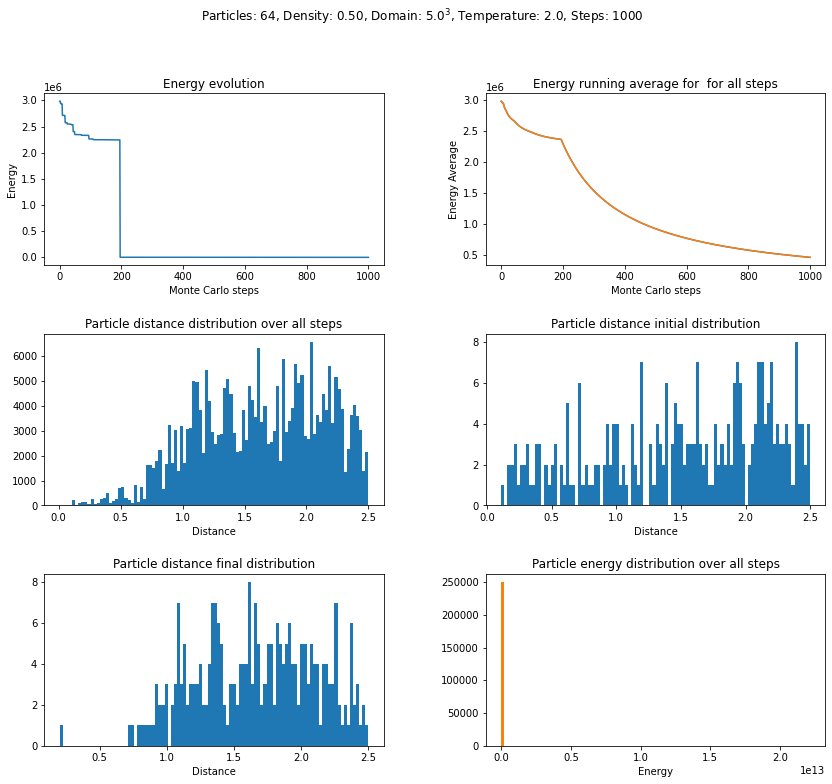

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(14,12), squeeze=False)
fig.suptitle('Particles: {}, Density: {:.2f}, Domain: ${}^3$, Temperature: {}, Steps: {}'.format(
    PARTICLES+1, DENSITY, RANGE, TEMPERATURE, STEPS))

ax[0][0].set_title('Energy evolution')
ax[0][0].plot(energy)
ax[0][0].set_xlabel('Monte Carlo steps')
ax[0][0].set_ylabel('Energy')

ax[0][1].set_title('Energy running average for  for all steps')
ax[0][1].plot(av_energy)
ax[0][1].set_xlabel('Monte Carlo steps')
ax[0][1].set_ylabel('Energy Average')

ax[0][1].set_title('Energy running average for  for all steps')
ax[0][1].plot(av_energy)
ax[0][1].set_xlabel('Monte Carlo steps')
ax[0][1].set_ylabel('Energy Average')

ax[1][0].set_title('Particle distance distribution over all steps')
ax[1][0].hist(dist_distr, bins=100)
ax[1][0].set_xlabel('Distance')

ax[1][1].set_title('Particle distance initial distribution')
ax[1][1].hist(dist_distr_init, bins=100)
ax[1][1].set_xlabel('Distance')

ax[2][0].set_title('Particle distance final distribution')
ax[2][0].hist(dist_distr_final, bins=100)
ax[2][0].set_xlabel('Distance')

ax[2][1].set_title('Particle energy distribution over all steps')
ax[2][1].hist(pair_energy_distr, bins=100)
ax[2][1].set_xlabel('Energy')
plt.hist(pair_energy_distr, bins=100)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
plt.savefig('p64d5t1000te2.png')
plt.show()

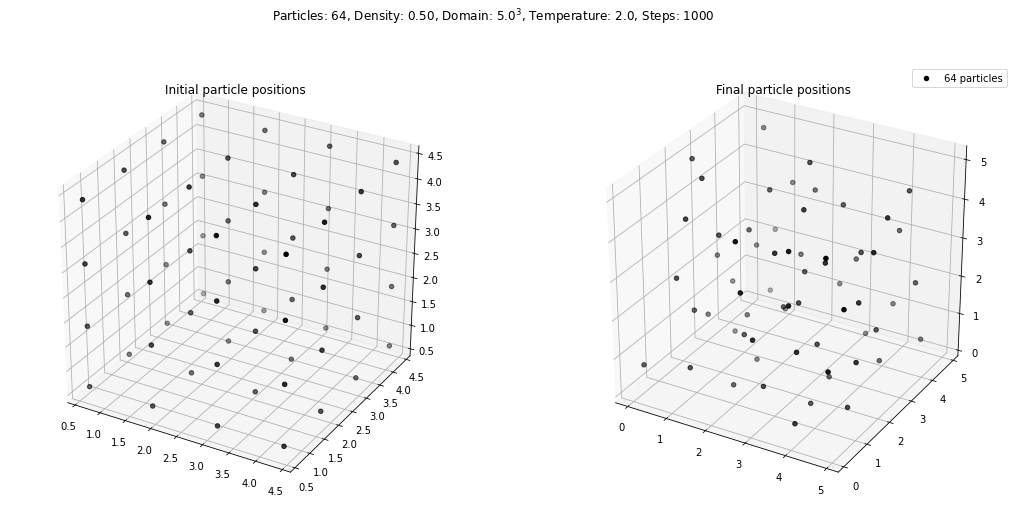

In [ ]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(121, projection='3d')
fig.suptitle('Particles: {}, Density: {:.2f}, Domain: ${}^3$, Temperature: {}, Steps: {}'.format(
    PARTICLES+1, DENSITY, RANGE, TEMPERATURE, STEPS))

xs = [x[0] for x in initial_positions]
ys = [x[1] for x in initial_positions]
zs = [x[2] for x in initial_positions]

ax.set_title('Initial particle positions')
ax.scatter(xs, ys, zs, color='black', label=f'{len(initial_positions)} particles' 
           if i == CUBES_PER_DIM**DIMS-1 else '')
        

ax = fig.add_subplot(122, projection='3d')

xs = [x[0] for x in particles]
ys = [x[1] for x in particles]
zs = [x[2] for x in particles]

ax.set_title('Final particle positions')
ax.scatter(xs, ys, zs, color='black', label=f'{len(particles)} particles' 
           if i == CUBES_PER_DIM**DIMS-1 else '')
        
plt.legend()
plt.gcf().gca()
plt.savefig('p64d5t1000te2pos.png')
plt.show()

In [ ]:
print(rate, STEPS)

1 1000


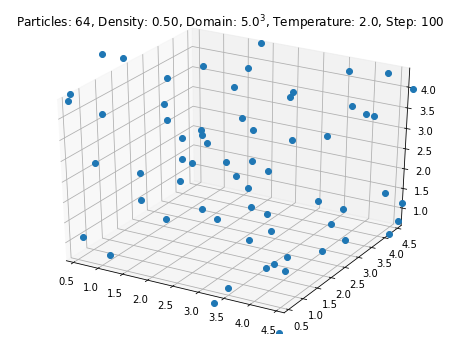

In [ ]:
import matplotlib.animation
import pandas as pd
from matplotlib import rc

rc('animation', html='jshtml')

def update_graph(num):
  p = particle_pos[num]
  xs = [x[0] for x in p]
  ys = [x[1] for x in p]
  zs = [x[2] for x in p]
  graph.set_data (xs, ys)
  graph.set_3d_properties(zs)
  title.set_text('Particles: {}, Density: {:.2f}, Domain: ${}^3$, Temperature: {}, Step: {}'.format(
    PARTICLES+1, DENSITY, RANGE, TEMPERATURE, num*10))
  return title, graph,

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

xs = [x[0] for x in initial_positions]
ys = [x[1] for x in initial_positions]
zs = [x[2] for x in initial_positions]

graph, = ax.plot(xs, ys, zs, linestyle="", marker="o")

anim = matplotlib.animation.FuncAnimation(fig, update_graph, 
                                          len(particle_pos), blit=True)
Writer = matplotlib.animation.writers['ffmpeg']
writer = Writer(fps=6, metadata=dict(artist='etsigkanos'), bitrate=1800)

anim.save('p64d5t1000te2anim.mp4', writer=writer)
anim